# Систем за препораки на филмови користејќи КNN
<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random 
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip -n ml-25m.zip

## Вчитување на податоците

### База на податоци за оценка на филмови од страна на корисници

In [2]:
dataset = pd.read_csv('ml-25m/ratings.csv')
dataset.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### База на податоци за име на филмот и жанрот

In [3]:
items_dataset = pd.read_csv('ml-25m/movies.csv')
items_dataset.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movie_dataset = items_dataset[['movieId','title']]
movie_dataset.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


## Спојување на податоците

In [5]:
merged_dataset = pd.merge(dataset, movie_dataset, how='inner', on='movieId')
merged_dataset.head()

,userId,movieId,rating,timestamp,title
0,1,296,5.0,1147880044,Pulp Fiction (1994)
1,3,296,5.0,1439474476,Pulp Fiction (1994)
2,4,296,4.0,1573938898,Pulp Fiction (1994)
3,5,296,4.0,830786155,Pulp Fiction (1994)
4,7,296,4.0,835444730,Pulp Fiction (1994)


In [6]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})
refined_dataset.head()

,userId,title,rating
0,1,2046 (2004),4.5
1,1,5x2 (2004),3.5
2,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.5
3,1,Back to the Future Part II (1989),2.5
4,1,Back to the Future Part III (1990),2.5


Се создава нова база на податоци со групирање на уникатната корисничка идентификација, комбинацијата на наслови на филмот и оценките од страна на корисникот за истиот филм. Ако корисникот оценува ист филм повеќе пати се зима средна вредност како рејтинг.

Пример за повеќекратно сценарио за оценување од корисник на одреден филм:

In [7]:
merged_dataset[(merged_dataset['title'] == 'Confessions of a Dangerous Mind (2002)') & (merged_dataset['userId'] == 1428)]

,userId,movieId,rating,timestamp,title
21739735,1428,6003,3.5,1542458392,Confessions of a Dangerous Mind (2002)
23679154,1428,144606,4.0,1542458936,Confessions of a Dangerous Mind (2002)


In [63]:
refined_dataset[(refined_dataset['title'] == 'Confessions of a Dangerous Mind (2002)') & (refined_dataset['userId'] == 1428)]

,userId,title,rating
201769,1428,Confessions of a Dangerous Mind (2002),3.75


In [7]:
print('Број на тргнати дупликати е',len(merged_dataset) - len(refined_dataset))

Број на тргнати дупликати е 609


In [7]:
num_users = len(refined_dataset['userId'].value_counts())
num_films = len(refined_dataset['title'].value_counts())
print(f"Бројот на корисници во базата на податоци: {num_users:,}")
print(f"Бројот на филмови во базата на податоци: {num_films:,}")

Бројот на корисници во базата на податоци: 162,541
Бројот на филмови во базата на податоци: 58,958


## Истражување и визуелизација на податоците

### Исцртување на бројот на секоја оцена

In [39]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
0.50,393051
0.75,3
1.00,776797
1.25,5
1.50,399474
1.75,9
2.00,1640793
2.25,31
2.50,1262707


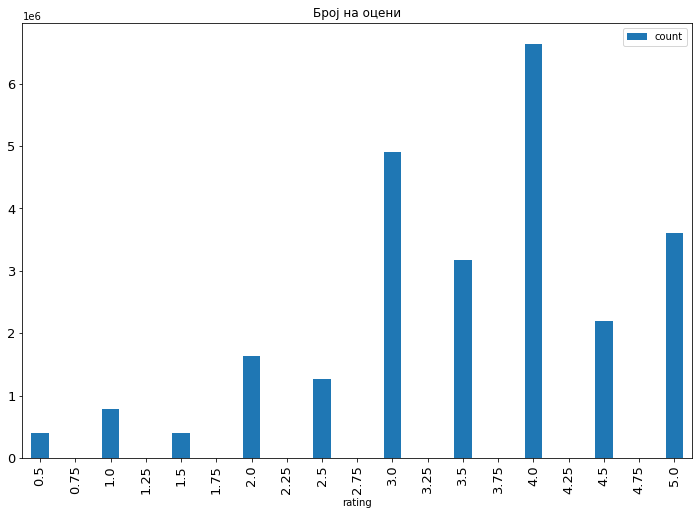

In [40]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Број на оцени',
    fontsize=13)

Можеме да видиме дека броевите меѓу основните (1, 1.5, 2, ...) од корисниците се релативно занемарливи. Односто тие се од корисниците кои имаа повеќе од еден рејтинг на истиот филм.  

Оценките за филмовите што не ги гледа корисникот стандардно се сметаат како 0. Ако се пресмета испаѓа многу голема бројка.

In [10]:
total_count = num_films * num_users
zero_count = total_count-refined_dataset.shape[0]
print(f"{zero_count:,}")

9,558,092,792


###  Исцртување на бројот на оцени за секој филм

In [8]:
movies_count_df = pd.DataFrame(refined_dataset.groupby('title').size(), columns=['count'])
movies_count_df.head()

,count
title,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",1
"""Great Performances"" Cats (1998)",179
#1 Cheerleader Camp (2010),9
#Captured (2017),2
#Female Pleasure (2018),3


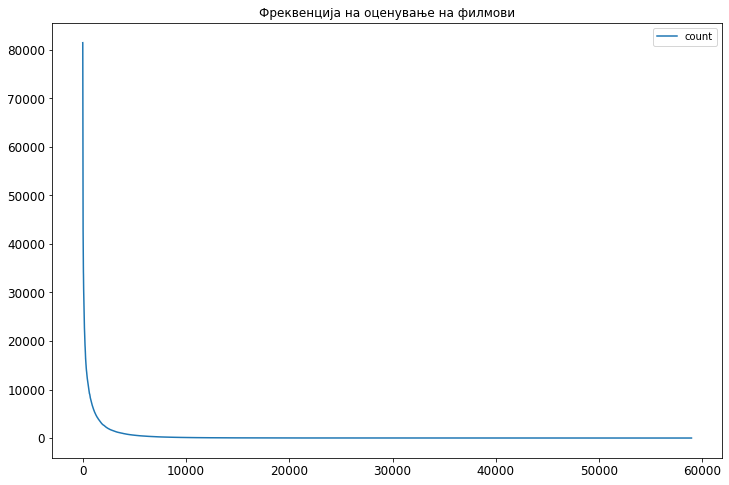

In [13]:
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Фреквенција на оценување на филмови',
        fontsize=12
    )

Бидејќи големината на базата на податоци избрана за овој проект е голема. Има потреба од отстранување на ретко оценети филмови или корисници кои дале оцена за помалку филмови.

Го гледаме својството на долга опашка, само мал дел од предметите се често оценети, така неречени популарни предмети. Огромното мнозинство на ставки ретко се оценуваат.

## Прочистување на податоците

### Исфрлање на филмови со малку рејтинзи

In [10]:
temp = movies_count_df[movies_count_df['count'] < 1000] # pomalku od 1000 rejtinzi
popular_movies_dataset = refined_dataset[~refined_dataset['title'].isin(temp["count"].keys())]

Ги тргаме непознатите филмови, но треба да се разгледа компромисот бидејќи многу филмови ќе се изгубат за минимален пад на оригиналното множество. 
Во мојот случај одбрав прагот да биде 1000 оцени, каде испадна дека губиме скро 93 посто од филмовите, а новиот датасет има пад од 11 проценти што е многу малку. 
Како се зголемува прагот, имаме голем пад на можни филмови што е прилично лошо, но треба да има одреден праг бидејки за филмовите со мал број на оцени ќе имаме големи грешки при предикција. Исто така имаме и проблем со меморијата, додека се извршуваше стигна максимално и до 10Gb. 

In [11]:
(100*(len(temp)))/len(movies_count_df), (100*(len(refined_dataset)-len(popular_movies_dataset)))/len(refined_dataset)

(93.56491061433563, 11.429738995433746)

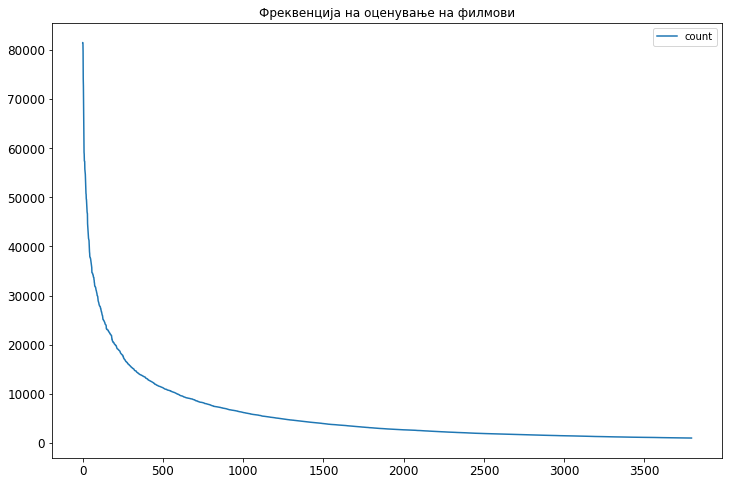

In [41]:
popular_movies_count_df = pd.DataFrame(popular_movies_dataset.groupby('title').size(), columns=['count'])
ax = popular_movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Фреквенција на оценување на филмови',
        fontsize=12
    )

### Исфрлање на корисници

In [12]:
user_count_df = pd.DataFrame(refined_dataset.groupby('userId').size(), columns=['count'])
user_count_df.sort_values('count',ascending=False)

,count
userId,
72315,32175
80974,9177
137293,8911
33844,7918
20055,7487
...,...
12094,20
119539,20
156759,20


In [13]:
user_count_df = pd.DataFrame(popular_movies_dataset.groupby('userId').size(), columns=['count'])
user_count_df.sort_values('count',ascending=False)

,count
userId,
57548,3459
72315,3422
20055,3175
107650,2928
80974,2915
...,...
143311,2
109980,2
8838,2


Кај корисниците имаме комплициран случај каде треба да трегнеме корисници и во двата екстреми. Ако се споредат оригиналната и новата датабаза со популарните филмови испага дека имаме ботови кои ги имаат оценето скоро сите филмови, најочигледно е кај најголемиот корисник. Мал процент од корисниците имаат многу оцени што реално не е физички способно да ги има изгледано сите филмови. Ако сметаме еден филм во просек е 2 сати, испага дека имаат гледано фкупно околу 2 години нонстоп.

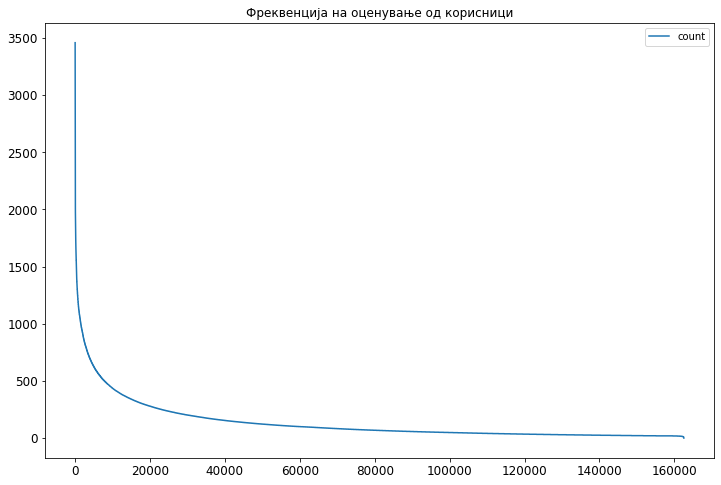

In [42]:
ax = user_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Фреквенција на оценување од корисници',
        fontsize=12
    )

In [15]:
temp = user_count_df[(user_count_df['count'] > 800) | (user_count_df['count'] < 30)]
final_dateset = popular_movies_dataset[~popular_movies_dataset.userId.isin(temp["count"].keys())]

За да добијам најдобра репрезентација на корисници:
1. Се тргаат корисниците кои имаат мал број на оцени, колку прагот е погоре толку повеке корисници се тргнати, но податочноот множество не се намалува исто како случајот со филмовите
2. Се тргаат корисниците со многу голем број на оцени кои преставуваат мал процент од корисниците, но податочното множество значително се намалува.

За најоптимални резлутати одбрав од опсег од 30 до 800 оцени по корисник каде произведе намалување на датасетот од 30 посто. Исто така имаме и подобрување на кривата каде долгата опашка е поблага.

In [43]:
(100*len(temp))/len(user_count_df), (100*(len(popular_movies_dataset)-len(final_dateset)))/len(popular_movies_dataset)

(24.125902091190422, 31.600055279284586)

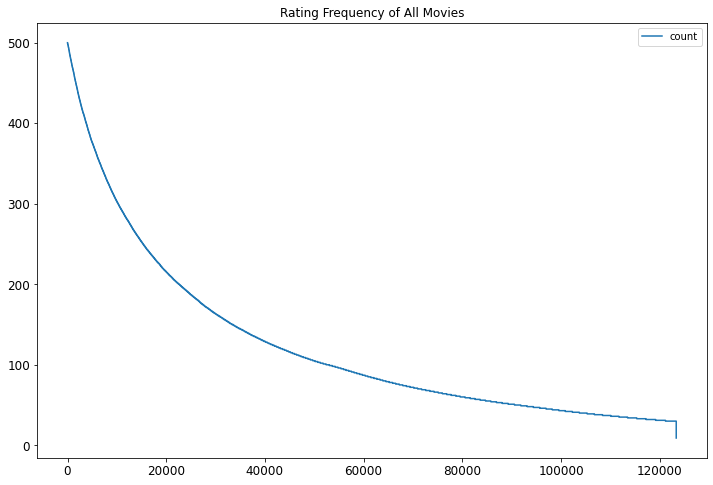

In [44]:
trimed_user_count_dfs = pd.DataFrame(final_dateset.groupby('userId').size(), columns=['count'])
ax = trimed_user_count_dfs \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )

Последната опција е каде по случаен избор може да се тргнат одреден процент од корисниците.

In [39]:
x = random.sample(range(1,len(final_dateset)), len(final_dateset)//3)
trimmed_dataset = final_dateset.query('userId not in @x')
trimmed_dataset.head()

,userId,title,rating
0,1,2046 (2004),4.5
1,1,5x2 (2004),3.5
2,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.5
3,1,Back to the Future Part II (1989),2.5
4,1,Back to the Future Part III (1990),2.5


## Споредба помеѓу податочните множества

In [45]:
print( 100*(num_users - len(final_dateset['userId'].value_counts()))/num_users, 
       100*(num_films - len(final_dateset['title'].value_counts()))/num_films, 
       100*(len(refined_dataset) - len(final_dateset))/len(refined_dataset))

24.126220461298995 93.56491061433563 39.41799043388332


При исфралање на 20% од корисниците и 90% од филмовите успеавме да остраниме само 25% од датасетот што не е толку добро, но треба да се направи компромис кој во мојот случај највеќе зависи до машината па затоа требаше драстично да се намали бројот на филмови.

## Креирање на корисник

In [18]:
movies_list = final_dateset.drop_duplicates(subset=['title'])['title'].values.tolist()
case_insensitive_movies_list = [i.lower() for i in movies_list]

In [19]:
def get_possible_movies(movie):
  temp = ''
  possible_movies = case_insensitive_movies_list.copy()
  for i in movie :
    out = []
    temp += i
    for j in possible_movies:
      if temp in j:
        out.append(j)
    if len(out) == 0:
        return possible_movies
    out.sort()
    possible_movies = out.copy()

  return possible_movies

In [20]:
class invalid(Exception):
    pass

def movie_rating():
  global final_dateset
  try:
    movie_name = input("Внеси име на филм: ")
    movie_name_lower = movie_name.lower()
    if movie_name_lower not in case_insensitive_movies_list :
      raise invalid
    else :
      rating = int(input("Внеси рејтинг на филм [1,5]: "))
      df = pd.DataFrame({'userId': [num_users+1], 
                          'title': [movie_name], 
                          'rating': [rating]})
      final_dateset = pd.concat([final_dateset, df], ignore_index = True, axis = 0)
      
  except invalid:

    possible_movies = get_possible_movies(movie_name_lower)
    if len(possible_movies) == len(movies_list) :
      print("Филмот не постои во датабазата")
    else :
      indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
      print("Внесеното име на филмот не се совпаѓа со ниту еден филм од базата на податоци. Ве молиме проверете ги долунаведените предлози :\n",[movies_list[i] for i in indices])
      movie_rating()

In [30]:
movie_rating()

Внесеното име на филмот не се совпаѓа со ниту еден филм од базата на податоци. Ве молиме проверете ги долунаведените предлози :
 ['101 Dalmatians (1996)', '101 Dalmatians (One Hundred and One Dalmatians) (1961)', '102 Dalmatians (2000)']


In [29]:
final_dateset[final_dateset['userId'] == num_users+1]

,userId,title,rating
15145182,162542,Star Trek (2009),5.0
15145183,162542,Star Trek Beyond (2016),5.0
15145184,162542,Solo: A Star Wars Story (2018),3.0
15145185,162542,Star Wars: Episode I - The Phantom Menace (1999),4.0
15145186,162542,Star Wars: The Last Jedi (2017),4.0
15145187,162542,"Godfather: Part II, The (1974)",4.0
15145188,162542,Rogue One: A Star Wars Story (2016),2.0
15145189,162542,Star Wars: Episode V - The Empire Strikes Back...,5.0


# Тренирање на модел за KNN

**Преобликување на податочната база**

Треба да ги трансформираме (во овој случај преобликуваме) податоците на таков начин што секој ред од податочната рамка претставува филм, а секоја колона претставува различен корисник.

За да ја преобликуваме податочната рамка, ќе ја свртиме податочната рамка во широк формат со филмови како редови и корисници како колони. Бидејќи знаеме дека не сите корисници ги гледаат сите филмови, можеме да очекуваме многу вредности што недостасуваат. Ќе треба да ги пополниме тие забелешки кои недостасуваат со 0, бидејќи ќе извршиме линеарни алгебарски операции (пресметување растојанија помеѓу вектори).

Конечно, ги трансформираме вредностите на податочната рамка во матрица за најефикасните пресметки и потоа се внесува во модел на КNN.

In [31]:
user_enc = LabelEncoder()
final_dateset['userId'] = user_enc.fit_transform(final_dateset['userId'].values)
n_users = final_dateset['userId'].nunique()

In [32]:
# pivot and create movie-user matrix
user_to_movie_df = final_dateset.pivot(
    index='userId',
     columns='title',
      values='rating').fillna(0)

user_to_movie_df.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),...,Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),Zulu (1964),[REC] (2007),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<123326x3794 sparse matrix of type '<class 'numpy.float64'>'
	with 15145191 stored elements in Compressed Sparse Row format>

In [34]:
knn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [35]:
def get_similar_users(user, n = 5):
  knn_input = np.asarray([user_to_movie_df.values[user]]) 
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
  print("Топ",n,"корисници кои се многу слични на Корисникот ",user, "се: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". Корисник:", indices[0][i], "e разделен со растојание од",distances[0][i])
  return indices.flatten()[1:], distances.flatten()[1:]

In [36]:
def recommender_system(user_id, n_similar_users, n_movies):
  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list) # tezini koj ke se nanesat na rejtingot na korsnicite
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Филмови препорачани врз основа на сличните корисници се: ")
  print("")
  # filtranje na filmovite ostranuvajki gi tie sto veke se videni 
  first_zero_index = np.where(mean_rating_list == 0)[0][-1]
  sortd_index = np.argsort(mean_rating_list)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n_movies)
  movies_watched = list(final_dateset[final_dateset['userId'] == user_id]['title'])
  filtered_movie_list = list(movies_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("Нема други филмови што не се гледани од слични корисници.")
  pprint(final_movie_list)

In [37]:
print("Број на слични корисници да се пронајдат:")
sim_users = int(input())
print("Број на филмови да се препорачаат:")
n_movies = int(input())
recommender_system(n_users-1,sim_users,n_movies)

Број на слични корисници да се пронајдат:
Број на филмови да се препорачаат:
Топ 10 корисници кои се многу слични на Корисникот  123325 се: 
 
1 . Корисник: 53350 e разделен со растојание од 0.705336079508095
2 . Корисник: 76858 e разделен со растојание од 0.7070812265204756
3 . Корисник: 70972 e разделен со растојание од 0.7216025353648206
4 . Корисник: 40971 e разделен со растојание од 0.7280061145614316
5 . Корисник: 69342 e разделен со растојание од 0.7285042063433216
6 . Корисник: 110100 e разделен со растојание од 0.7349384895598521
7 . Корисник: 33728 e разделен со растојание од 0.7353485952865815
8 . Корисник: 81776 e разделен со растојание од 0.7357037012360865
9 . Корисник: 68231 e разделен со растојание од 0.736791817111593
10 . Корисник: 75670 e разделен со растојание од 0.7396736082239239

Филмови препорачани врз основа на сличните корисници се: 

['Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Star Wars: Episode VII - 

Интересна опсервација би била дека горенаведениот модел на KNN препорачува филмови кои се прилично добри и имаат смисла. Сепак, косинусното растојание на сите тие препораки се забележува дека е всушност прилично мало. Ова може да биде затоа што има премногу нула вредности во нашата матрица филм-корисник. Со премногу нула вредности во нашите податоци, реткоста на податоците станува вистински проблем за KNN моделот и растојанието во моделот KNN почнува да се распаѓа.

In [50]:
num_entries = user_to_movie_df.shape[0] * user_to_movie_df.shape[1]
num_zeros = (user_to_movie_df==0).sum(axis=1).sum()
ratio_zeros = num_zeros / num_entries
print('{:.2%} од рејтингот во нашите податоци недостасува'.format(ratio_zeros))

96.76% од рејтингот во нашите податоци недостасува


Овој резултат ја потврдува горната хипотеза. Огромното мнозинство на записи во нашите податоци е нула, но има потенцијално решение со имплементација на длабоки невронски мрежи каде овој проблем нема толку да влијае.